In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import itertools
from copy import deepcopy
from abc import ABC, abstractmethod
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm

# Classes

### Static Data

In [2]:
class TransitionMatrix:
    
    def __init__(self, transition_matrix: pd.DataFrame, horizon: float):
        self.transition_matrix = transition_matrix
        self.horizon = horizon
        self.__check_input_matrix()
        
    def __check_input_matrix(self):
        ratings = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'Default']
        if list(self.transition_matrix.index) != ratings:
            raise ValueError('The input transition_matrix is not composed of the allowed rating (index): ' + str(ratings))
        if list(self.transition_matrix.columns) != ratings:
            raise ValueError('The input transition_matrix is not composed of the allowed rating (columns): ' + str(ratings))
    
    def get_transition_probability(self, initial_rating: str, new_rating: str):
        return self.transition_matrix.loc[initial_rating, new_rating]
    

### Market Data

In [3]:
class InterestRateCurve:
    
    def __init__(self, name:str, curve: np.ndarray, maturities: np.ndarray):
        self.name = name
        self.curve = curve
        self.maturities = maturities
    
    def get_rate(self, maturity: int):
        if maturity == 0:
            raise ValueError('The maturity has to be above 0.')
        rate = self.curve[maturity-1]
        return rate
    

In [4]:
class Market:
    
    def __init__(self, list_market_data: list):
        self.list_market_data = list_market_data
        
    def get_market_data(self, id_market_data: str):
        for market_data in self.list_market_data:
            if market_data.name==id_market_data:
                return market_data
        raise ValueError("The id_market_data " + str(id_market_data) + " is not in the Market.")


### Bonds

In [5]:
class Bond:
    
    def __init__(self, rating: str, nominal: float, coupon_rate: float, maturity: int, recovery_rate: float):
        self.rating = rating
        self.nominal = nominal
        self.coupon_rate = coupon_rate
        self.maturity = maturity
        self.recovery_rate = recovery_rate
        

In [6]:
class BondValuationModel(ABC):
    
    @abstractmethod
    def price(self):
        pass

In [7]:
class BondVanillaValuationModel(BondValuationModel):
    
    def price(self, bond: Bond, ir_curve: InterestRateCurve):
        if bond.rating == 'Default':
            return self.__price_defaulted_bond(bond)
        coupon_value = bond.nominal * bond.coupon_rate
        market_value = 0
        for i in range(bond.maturity):
            market_value += coupon_value / (1 + ir_curve.get_rate(i+1)) ** (i+1)
        market_value += bond.nominal / (1 + ir_curve.get_rate(bond.maturity)) ** bond.maturity
        return market_value
    
    def __price_defaulted_bond(self, bond: Bond):
        if bond.recovery_rate >= 0:
            return bond.recovery_rate * bond.nominal
        else:
            return 0.0

In [8]:
model = BondVanillaValuationModel()

### Portfolio

In [9]:
class Portfolio:
    
    def __init__(self, list_derivatives: list):
        self.list_derivatives = list_derivatives
        

# Exercice 1 - Credit Value at Risk with independance

Please consider a portfolio of two bonds:
* Rating A with nominal 100, 5% interest rate, 3Y maturity and 45% recovery rate
* Rating BBB with nominal 100, 6% interest rate, 5Y maturity and 45% recovery rate

The aim of this exercice is to compute the Credit Value at Risk, given a forward market and a transition matrix (independant transitions).

### Transition matrix

In [10]:
ratings = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'Default']

df_transition_exercice_1 = pd.DataFrame(index=ratings, columns=ratings)
df_transition_exercice_1['AAA'] = [90.81, 0.70, 0.09, 0.02, 0.03, 0.00, 0.22, 0.00]
df_transition_exercice_1['AA'] = [8.33, 90.65, 2.27, 0.33, 0.14, 0.11, 0.00, 0.00]
df_transition_exercice_1['A'] = [0.68, 7.79, 91.05, 5.95, 0.67, 0.24, 0.22, 0.00]
df_transition_exercice_1['BBB'] = [0.06, 0.64, 5.52, 86.93, 7.73, 0.43, 1.30, 0.00]
df_transition_exercice_1['BB'] = [0.12, 0.06, 0.74, 5.30, 80.53, 6.48, 2.38, 0.00]
df_transition_exercice_1['B'] = [0.00, 0.14, 0.26, 1.17, 8.84, 83.46, 11.24, 0.00]
df_transition_exercice_1['CCC'] = [0.00, 0.02, 0.01, 0.12, 1.00, 4.07, 64.86, 0.00]
df_transition_exercice_1['Default'] = [0.00, 0.00, 0.06, 0.18, 1.06, 5.20, 19.79, 100.00]

In [11]:
print('First, we can verify that the sum of the transition probabilities is 1.0:')
print()
print(df_transition_exercice_1.sum(axis=1))
print()
print()
print('Transition Probabilities :')
print()
df_transition_exercice_1

First, we can verify that the sum of the transition probabilities is 1.0:

AAA        100.00
AA         100.00
A          100.00
BBB        100.00
BB         100.00
B           99.99
CCC        100.01
Default    100.00
dtype: float64


Transition Probabilities :



,AAA,AA,A,BBB,BB,B,CCC,Default
AAA,90.81,8.33,0.68,0.06,0.12,0.00,0.00,0.00
AA,0.70,90.65,7.79,0.64,0.06,0.14,0.02,0.00
A,0.09,2.27,91.05,5.52,0.74,0.26,0.01,0.06
BBB,0.02,0.33,5.95,86.93,5.30,1.17,0.12,0.18
BB,0.03,0.14,0.67,7.73,80.53,8.84,1.00,1.06
B,0.00,0.11,0.24,0.43,6.48,83.46,4.07,5.20
CCC,0.22,0.00,0.22,1.30,2.38,11.24,64.86,19.79
Default,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00


In [12]:
transition_matrix_1_y_exercice_1 = TransitionMatrix(df_transition_exercice_1, 1)

In [13]:
transition_matrix_1_y_exercice_1.get_transition_probability(initial_rating='A', new_rating='A')

91.05

### Market data

In [14]:
maturities = np.array([1, 2, 3, 4])

aaa_rates = np.array([0.0360, 0.0417, 0.0473, 0.0512])
aaa_ir_curve = InterestRateCurve(name='AAA', curve=aaa_rates, maturities=maturities)

aa_rates = np.array([0.0365, 0.0422, 0.0478, 0.0517])
aa_ir_curve = InterestRateCurve(name='AA', curve=aa_rates, maturities=maturities)

a_rates = np.array([0.0372, 0.0432, 0.0493, 0.0532])
a_ir_curve = InterestRateCurve(name='A', curve=a_rates, maturities=maturities)

bbb_rates = np.array([0.0410, 0.0467, 0.0525, 0.0563])
bbb_ir_curve = InterestRateCurve(name='BBB', curve=bbb_rates, maturities=maturities)

bb_rates = np.array([0.0555, 0.0602, 0.0678, 0.0727])
bb_ir_curve = InterestRateCurve(name='BB', curve=bb_rates, maturities=maturities)

b_rates = np.array([0.0605, 0.0702, 0.0803, 0.0852])
b_ir_curve = InterestRateCurve(name='B', curve=b_rates, maturities=maturities)

ccc_rates = np.array([0.1505, 0.1502, 0.1403, 0.1352])
ccc_ir_curve = InterestRateCurve(name='CCC', curve=ccc_rates, maturities=maturities)

default_rates = np.array([])
default_ir_curve = InterestRateCurve(name='Default', curve=default_rates, maturities=maturities)

In [15]:
forward_market_exercice_1 = Market([aaa_ir_curve, aa_ir_curve, a_ir_curve, bbb_ir_curve, bb_ir_curve, b_ir_curve, ccc_ir_curve, default_ir_curve])

In [16]:
forward_market_exercice_1.get_market_data('A').get_rate(maturity=2)

0.0432

### Portfolio

In [17]:
bond_1 = Bond(rating='A', nominal=100, coupon_rate=0.05, maturity=3, recovery_rate=0.45)
bond_2 = Bond(rating='BBB', nominal=100, coupon_rate=0.06, maturity=5, recovery_rate=0.45)
portfolio_exercice_1 = Portfolio(list_derivatives=[bond_1, bond_2])

In [18]:
# Tests pricing

# We simulate the one year horizon of the VaR, by adding the coupons
bond_test_1 = Bond(rating='A', nominal=100, coupon_rate=0.05, maturity=2, recovery_rate=0.45)
bond_test_2 = Bond(rating='BBB', nominal=100, coupon_rate=0.06, maturity=4, recovery_rate=0.45)
print('With first coupon')
print('Bond_1:', model.price(bond_test_1, forward_market_exercice_1.get_market_data(bond_test_1.rating)) + bond_test_1.coupon_rate*bond_test_1.nominal)
print('Bond_2:', model.price(bond_test_2, forward_market_exercice_1.get_market_data(bond_test_2.rating)) + bond_test_2.coupon_rate*bond_test_2.nominal)
print()
print('Without first coupon')
print('Bond_1:', model.price(bond_test_1, forward_market_exercice_1.get_market_data(bond_test_1.rating)))
print('Bond_2:', model.price(bond_test_2, forward_market_exercice_1.get_market_data(bond_test_2.rating)))

With first coupon
Bond_1: 106.30441383916988
Bond_2: 107.53094386580608

Without first coupon
Bond_1: 101.30441383916988
Bond_2: 101.53094386580608


### Credit Value at Risk

In [19]:
class CreditVarEngineExercie1:
    
    def __init__(self):
        self.rating = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'Default']
    
    def compute(self, portfolio: Portfolio, transition_matrix: TransitionMatrix, model: BondValuationModel, forward_market: Market, horizon: int, probability: float):
        portfolio = self.update_maturity(portfolio, horizon)
        scenarios = self.generate_scenarios(portfolio)
        scenarios_valuations = self.valuate_scenarios(scenarios, model, forward_market, horizon, portfolio)
        scenarios_probabilities = self.compute_scenario_probabilities(portfolio, scenarios, transition_matrix)
        return self.evaluate_credit_var(scenarios_valuations, scenarios_probabilities, probability)
    
    def update_maturity(self, portfolio: Portfolio, horizon: int):
        portfolio_temp = deepcopy(portfolio)
        for bond in portfolio_temp.list_derivatives:
            bond.maturity -= horizon
        return portfolio_temp
    
    
    # Scenarios generation
    
    def generate_scenarios(self, portfolio: Portfolio):
        list_possible_rating = self.__generate_grid(portfolio)
        return self.__generate_list_portfolios(list_possible_rating, portfolio)
        
    def __generate_grid(self, portfolio: Portfolio):
        list_possible_rating = []
        for bond in portfolio.list_derivatives:
            list_possible_rating.append(deepcopy(self.rating))
        return list(itertools.product(*list_possible_rating))
        
    def __generate_list_portfolios(self, list_possible_rating: list, portfolio: Portfolio):
        scenarios = []
        for scenario in list_possible_rating:
            scenarios.append(self.__create_portfolio_scenario(scenario, portfolio))
        return scenarios
            
    def __create_portfolio_scenario(self, ratings_scenario: list, portfolio: Portfolio):
        portfolio_temp = deepcopy(portfolio)
        for i in range(len(ratings_scenario)):
            portfolio_temp.list_derivatives[i].rating = ratings_scenario[i]
        return portfolio_temp
    
    
    # Scenarios valuation - naive approach
    
    def valuate_scenarios(self, scenarios: list, model: BondValuationModel, market: Market, horizon: int, portfolio: Portfolio):
        cash_flows = self.__compute_cash_flows(portfolio, horizon)
        valuations = []
        for scena in scenarios:
            valuations.append(self.__valuate_one_scenario(portfolio=scena, model=model, market=market) + cash_flows)
        return valuations
            
    def __valuate_one_scenario(self, portfolio: Portfolio, model: BondValuationModel, market: Market):
        value = 0.0
        for bond in portfolio.list_derivatives:
            value += model.price(bond, market.get_market_data(bond.rating))
        return value
    
    def __compute_cash_flows(self, portfolio: Portfolio, horizon: int):
        cash = 0.0
        for bond in portfolio.list_derivatives:
            cash += bond.coupon_rate * bond.nominal * horizon
        return cash
    
    
    # Scenarios probability
    
    def compute_scenario_probabilities(self, portfolio: Portfolio, scenarios: list, transition_matrix: TransitionMatrix):
        scenario_probabilities = []
        for scena in scenarios:
            scenario_probabilities.append(self.__compute_one_scenario_probability(scena, portfolio, transition_matrix))
        return scenario_probabilities
            
    def __compute_one_scenario_probability(self, portfolio_scenario: Portfolio, portfolio_initial: Portfolio, transition_matrix: TransitionMatrix):
        probability = 1.0
        for i in range(len(portfolio_scenario.list_derivatives)):
            probability *= transition_matrix.get_transition_probability(portfolio_initial.list_derivatives[i].rating, portfolio_scenario.list_derivatives[i].rating)/100
        return probability
    
    
    # Credit Value at Risk computation
    
    def evaluate_credit_var(self, scenarios_values: list, scenarios_probabilities: list, percentage_var: float):
        expectation = self.compute_expectation(scenarios_values, scenarios_probabilities)
        quantile = self.compute_quantile(scenarios_values, scenarios_probabilities, percentage_var)
        return expectation - quantile
    
    def compute_quantile(self, scenarios_values: list, scenarios_probabilities: list, percentage_var: float):
        # For more infos: https://www.kite.com/python/answers/how-to-sort-two-lists-together-in-python
        zipped_lists = zip(scenarios_values, scenarios_probabilities)
        sorted_pairs = sorted(zipped_lists)
        tuples = zip(*sorted_pairs)
        scenarios_values, scenarios_probabilities = [list(tuple_) for tuple_ in  tuples]
        sum_proba = 0.0
        for i in range(len(scenarios_probabilities)):
            sum_proba += scenarios_probabilities[i]
            if sum_proba > (1.0-percentage_var):
                return scenarios_values[i]
        raise ValueError('The sum of the scenarios_probabilities is below 1.0')
    
    def compute_expectation(self, scenarios_values: list, scenarios_probabilities: list):
        expectation = 0.0
        for i in range(len(scenarios_values)):
            expectation += scenarios_values[i] * scenarios_probabilities[i]
        return expectation
    
    def compute_standard_deviation(self, scenarios_values: list, scenarios_probabilities: list):
        expectation = self.compute_expectation(scenarios_values, scenarios_probabilities)
        variance = 0.0
        for i in range(len(scenarios_values)):
            variance += scenarios_probabilities[i] * (scenarios_values[i]-expectation)** 2 
        return np.sqrt(variance)
    
    def compute_proxy_credit_var(self, scenarios_values: list, scenarios_probabilities: list, percentage_var: float):
        return norm.ppf(percentage_var) * self.compute_standard_deviation(scenarios_values, scenarios_probabilities)

In [20]:
var_engine_exercice_1 = CreditVarEngineExercie1()

In [21]:
var_engine_exercice_1.compute(portfolio=portfolio_exercice_1, 
                              transition_matrix=transition_matrix_1_y_exercice_1, 
                              model=model, 
                              forward_market=forward_market_exercice_1, 
                              horizon=1, 
                              probability=0.99)

8.879585724939432

In [22]:
# Details
portfolio_temp_exercice_1 = var_engine_exercice_1.update_maturity(portfolio_exercice_1, 1)
scenarios_exercice_1 = var_engine_exercice_1.generate_scenarios(portfolio_temp_exercice_1)
scenarios_values_exercice_1 = var_engine_exercice_1.valuate_scenarios(scenarios=scenarios_exercice_1, 
                                                                      model=model, 
                                                                      horizon=1, 
                                                                      market=forward_market_exercice_1, 
                                                                      portfolio=portfolio_temp_exercice_1)
scenario_probability_exercice_1 = var_engine_exercice_1.compute_scenario_probabilities(portfolio_temp_exercice_1, 
                                                                                       scenarios_exercice_1, 
                                                                                       transition_matrix_1_y_exercice_1)
expectation_exercice_1 = var_engine_exercice_1.compute_expectation(scenarios_values_exercice_1, scenario_probability_exercice_1)
standard_dev_exercice_1 = var_engine_exercice_1.compute_standard_deviation(scenarios_values_exercice_1, scenario_probability_exercice_1)
quantile_99_exercice_1 = var_engine_exercice_1.compute_quantile(scenarios_values_exercice_1, scenario_probability_exercice_1, 0.99)
credit_var_exercice_1 = var_engine_exercice_1.evaluate_credit_var(scenarios_values_exercice_1, scenario_probability_exercice_1, 0.99)
proxy_credit_var_exercice_1 = var_engine_exercice_1.compute_proxy_credit_var(scenarios_values_exercice_1, scenario_probability_exercice_1, 0.99)

In [23]:
print('Expectation:', expectation_exercice_1)
print('Standard Deviation:', standard_dev_exercice_1)
print('Quantile 99%:', quantile_99_exercice_1)
print('Credit Value at Risk:', credit_var_exercice_1)
print('Proxy:', proxy_credit_var_exercice_1)

Expectation: 213.2699127447844
Standard Deviation: 3.324604372759668
Quantile 99%: 204.39032701984496
Credit Value at Risk: 8.879585724939432
Proxy: 7.734186314596337


# Exercice 2 - Credit Value at Risk with dependances

Please consider a portfolio of two bonds:
* Rating A with nominal 100, 5% interest rate, 3Y maturity and 45% recovery rate
* Rating BBB with nominal 100,, 6% interest rate, 5Y maturity and 45% recovery rate

The aim of this exercice is to compute the Credit Value at Risk, given a forward market and a transition matrix (non-independant transitions).
A study on the default probability is also expected.

### Portfolio

In [24]:
bond_1 = Bond(rating='A', nominal=100, coupon_rate=0.05, maturity=3, recovery_rate=0.45)
bond_2 = Bond(rating='BBB', nominal=100, coupon_rate=0.06, maturity=5, recovery_rate=0.45)
portfolio_exercice_2 = Portfolio(list_derivatives=[bond_1, bond_2])

### Market Data

In [25]:
maturities = np.array([1, 2, 3, 4])

aaa_rates = np.array([0.0360, 0.0417, 0.0473, 0.0512])
aaa_ir_curve = InterestRateCurve(name='AAA', curve=aaa_rates, maturities=maturities)

aa_rates = np.array([0.0365, 0.0422, 0.0478, 0.0517])
aa_ir_curve = InterestRateCurve(name='AA', curve=aa_rates, maturities=maturities)

a_rates = np.array([0.0372, 0.0432, 0.0493, 0.0532])
a_ir_curve = InterestRateCurve(name='A', curve=a_rates, maturities=maturities)

bbb_rates = np.array([0.0410, 0.0467, 0.0525, 0.0563])
bbb_ir_curve = InterestRateCurve(name='BBB', curve=bbb_rates, maturities=maturities)

bb_rates = np.array([0.0555, 0.0602, 0.0678, 0.0727])
bb_ir_curve = InterestRateCurve(name='BB', curve=bb_rates, maturities=maturities)

b_rates = np.array([0.0605, 0.0702, 0.0803, 0.0852])
b_ir_curve = InterestRateCurve(name='B', curve=b_rates, maturities=maturities)

ccc_rates = np.array([0.1505, 0.1502, 0.1403, 0.1352])
ccc_ir_curve = InterestRateCurve(name='CCC', curve=ccc_rates, maturities=maturities)

default_rates = np.array([])
default_ir_curve = InterestRateCurve(name='Default', curve=default_rates, maturities=maturities)

In [26]:
forward_market_exercice_2 = Market([aaa_ir_curve, aa_ir_curve, a_ir_curve, bbb_ir_curve, bb_ir_curve, b_ir_curve, ccc_ir_curve, default_ir_curve])

### Transition Probability Getter & Examples

In [27]:
transition_thresholds_exercice_2 = {}
transition_thresholds_exercice_2['AAA'] = [-1.329, -2.382, -2.911, -3.036, -100.000, -100.000, -100.000]
transition_thresholds_exercice_2['AA'] = [2.46, -1.36, -2.38, -2.85, -2.95, -3.54, -100.0]
transition_thresholds_exercice_2['A'] = [3.12, 1.98, -1.51, -2.30, -2.72, -3.19, -3.24]
transition_thresholds_exercice_2['BBB'] = [3.540, 2.70, 1.53, -1.49, -2.18, -2.75, -2.91]
transition_thresholds_exercice_2['BB'] = [3.432, 2.929, 2.391, 1.368, -1.232, -2.042, -2.304]
transition_thresholds_exercice_2['B'] = [10.0, 3.06, 2.70, 2.42, 1.46, -1.32, -1.62]
transition_thresholds_exercice_2['CCC'] = [2.85, 2.85, 2.62, 2.11, 1.74, 1.02, -0.85]
transition_thresholds_exercice_2['Default'] = [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]

In [28]:
class TransitionProbabilityGetter:
    
    def __init__(self, transition_thresholds):
        self.transition_thresholds = transition_thresholds
        
    def compute_scenario_probabilities(self, portfolio_scenario: Portfolio, portfolio_initial: Portfolio, cov_matrix: np.ndarray):
        x1, x2, y1, y2 = self.get_thresholds(portfolio_scenario, portfolio_initial)
        return self.compute_proba_from_thresholds(x1, x2, y1, y2, cov_matrix)
        
    def get_thresholds(self, portfolio_scenario: Portfolio, portfolio_initial: Portfolio):
        x1, x2 = self.get_one_bond_threshold(portfolio_scenario=portfolio_scenario, portfolio_initial=portfolio_initial, id_derivative=0)
        y1, y2 = self.get_one_bond_threshold(portfolio_scenario=portfolio_scenario, portfolio_initial=portfolio_initial, id_derivative=1)
        return x1, x2, y1, y2
    
    def get_one_bond_threshold(self, portfolio_scenario: Portfolio, portfolio_initial: Portfolio, id_derivative: int):
        if portfolio_scenario.list_derivatives[id_derivative].rating == 'AAA':
            x2 = 100
            x1 = self.transition_thresholds[portfolio_initial.list_derivatives[id_derivative].rating][0]
        elif portfolio_scenario.list_derivatives[id_derivative].rating == 'AA':
            x2 = self.transition_thresholds[portfolio_initial.list_derivatives[id_derivative].rating][0]
            x1 = self.transition_thresholds[portfolio_initial.list_derivatives[id_derivative].rating][1]
        elif portfolio_scenario.list_derivatives[id_derivative].rating == 'A':
            x2 = self.transition_thresholds[portfolio_initial.list_derivatives[id_derivative].rating][1]
            x1 = self.transition_thresholds[portfolio_initial.list_derivatives[id_derivative].rating][2]
        elif portfolio_scenario.list_derivatives[id_derivative].rating == 'BBB':
            x2 = self.transition_thresholds[portfolio_initial.list_derivatives[id_derivative].rating][2]
            x1 = self.transition_thresholds[portfolio_initial.list_derivatives[id_derivative].rating][3]
        elif portfolio_scenario.list_derivatives[id_derivative].rating == 'BB':
            x2 = self.transition_thresholds[portfolio_initial.list_derivatives[id_derivative].rating][3]
            x1 = self.transition_thresholds[portfolio_initial.list_derivatives[id_derivative].rating][4]
        elif portfolio_scenario.list_derivatives[id_derivative].rating == 'B':
            x2 = self.transition_thresholds[portfolio_initial.list_derivatives[id_derivative].rating][4]
            x1 = self.transition_thresholds[portfolio_initial.list_derivatives[id_derivative].rating][5]
        elif portfolio_scenario.list_derivatives[id_derivative].rating == 'CCC':
            x2 = self.transition_thresholds[portfolio_initial.list_derivatives[id_derivative].rating][5]
            x1 = self.transition_thresholds[portfolio_initial.list_derivatives[id_derivative].rating][6]
        elif portfolio_scenario.list_derivatives[id_derivative].rating == 'Default':
            x2 = self.transition_thresholds[portfolio_initial.list_derivatives[id_derivative].rating][6]
            x1 = -100
        return x1, x2

    def compute_proba_from_thresholds(self, x1, x2, y1, y2, cov_matrix: np.ndarray):
        mean = np.array([0,0])
        dist = mvn(mean=mean, cov=cov_matrix)
        probability = dist.cdf(np.array([x2,y2])) #P(X<x2, Y<y2)
        probability -= dist.cdf(np.array([x1,y2])) #P(X<x1, Y<y2)
        probability -= dist.cdf(np.array([x2,y1])) #P(X<x2, Y<y1)
        probability += dist.cdf(np.array([x1,y1])) #P(X<x1, Y<y1)
        return probability #P(x1<X<x2, y1<Y<y2)

In [29]:
transition_probability_getter = TransitionProbabilityGetter(transition_thresholds_exercice_2)

In [30]:
print(portfolio_exercice_2.list_derivatives[0].rating)
print(portfolio_exercice_2.list_derivatives[1].rating)

A
BBB


In [31]:
# Remember:
#bond_1 = Bond(rating='A', nominal=100, coupon_rate=0.05, maturity=3, recovery_rate=0.45)
#bond_2 = Bond(rating='BBB', nominal=100, coupon_rate=0.06, maturity=5, recovery_rate=0.45)

col_row = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'Default', 'Total']
correlated_transition = pd.DataFrame(index=col_row, columns=col_row)

correl = 0.0

covariance_exercice_2_temp = np.array([[1, correl],[correl, 1]])

portfolio_scenario_temp_bis = deepcopy(portfolio_exercice_2)
portfolio_scenario_temp_bis.list_derivatives[0].rating = 'A'
portfolio_scenario_temp_bis.list_derivatives[1].rating = 'BBB'

print('Transition proba to ' + str(portfolio_scenario_temp_bis.list_derivatives[0].rating) + ' and ' + str(portfolio_scenario_temp_bis.list_derivatives[1].rating)\
      +' with ' + str(correl*100) + '% correl:'\
    , transition_probability_getter.compute_scenario_probabilities(portfolio_scenario_temp_bis, portfolio_exercice_2, covariance_exercice_2_temp))

Transition proba to A and BBB with 0.0% correl: 0.7912247344849377


In [32]:
for ratingA in ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'Default']:
    for ratingB in ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'Default']:
        portfolio_scenario_temp = deepcopy(portfolio_exercice_2)
        portfolio_scenario_temp.list_derivatives[0].rating = ratingA
        portfolio_scenario_temp.list_derivatives[1].rating = ratingB
        correlated_transition.loc[ratingA, ratingB] = transition_probability_getter.compute_scenario_probabilities(portfolio_scenario_temp, portfolio_exercice_2, covariance_exercice_2_temp)
        
        
            
correlated_transition.loc['Total', :] = correlated_transition.sum(axis=0)
correlated_transition.loc[:, 'Total'] = correlated_transition.sum(axis=1)

In [33]:
print('initial rating oblig_1 (lignes):', portfolio_exercice_2.list_derivatives[0].rating)
print('initial rating oblig_2 (columns):', portfolio_exercice_2.list_derivatives[1].rating)

#pd.options.display.float_format = '{:.2%}'.format
correlated_transition = correlated_transition.style.format({'AAA':'{:.2%}', 'AA':'{:.2%}', 'A':'{:.2%}', 'BBB':'{:.2%}', 'BB':'{:.2%}', 'B':'{:.2%}', 'CCC':'{:.2%}', 'Default':'{:.2%}', 'Total':'{:.2%}'})
correlated_transition

initial rating oblig_1 (lignes): A
initial rating oblig_2 (columns): BBB


,AAA,AA,A,BBB,BB,B,CCC,Default,Total
AAA,0.00%,0.00%,0.01%,0.08%,0.00%,0.00%,0.00%,0.00%,0.09%
AA,0.00%,0.01%,0.14%,1.99%,0.12%,0.03%,0.00%,0.00%,2.29%
A,0.02%,0.30%,5.42%,79.12%,4.87%,1.06%,0.11%,0.16%,91.06%
BBB,0.00%,0.02%,0.33%,4.76%,0.29%,0.06%,0.01%,0.01%,5.48%
BB,0.00%,0.00%,0.04%,0.65%,0.04%,0.01%,0.00%,0.00%,0.75%
B,0.00%,0.00%,0.02%,0.22%,0.01%,0.00%,0.00%,0.00%,0.26%
CCC,0.00%,0.00%,0.00%,0.01%,0.00%,0.00%,0.00%,0.00%,0.01%
Default,0.00%,0.00%,0.00%,0.05%,0.00%,0.00%,0.00%,0.00%,0.06%
Total,0.02%,0.33%,5.95%,86.89%,5.35%,1.16%,0.12%,0.18%,100.00%


In [34]:
portfolio_scenario_temp = deepcopy(portfolio_exercice_2)
portfolio_scenario_temp.list_derivatives[0].rating = 'Default'
portfolio_scenario_temp.list_derivatives[1].rating = 'Default'

covariance_temp_1_exercice_2 = np.array([[1, 0.99],[0.99, 1]])

print('Default probability with 99% correl:', transition_probability_getter.compute_scenario_probabilities(portfolio_scenario_temp, 
                                                                                                           portfolio_exercice_2, 
                                                                                                           covariance_temp_1_exercice_2))

covariance_temp_2_exercice_2 = np.array([[1, 0.3],[0.3, 1]])
print('Default probability with 30% correl:', transition_probability_getter.compute_scenario_probabilities(portfolio_scenario_temp, 
                                                                                                           portfolio_exercice_2, 
                                                                                                           covariance_temp_2_exercice_2))

Default probability with 99% correl: 0.0005960209584683666
Default probability with 30% correl: 1.561189257274955e-05


### Part 1 - Default correlation

In [35]:
def compute_default_correlation(portfolio: Portfolio, transition_probability_getter: TransitionProbabilityGetter, covariance: np.ndarray):
    ratings = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'Default']
    # p(1,2)
    portfolio_temp = deepcopy(portfolio)
    portfolio_temp.list_derivatives[0].rating = 'Default'
    portfolio_temp.list_derivatives[1].rating = 'Default'
    p1_2 = transition_probability_getter.compute_scenario_probabilities(portfolio_temp, portfolio, covariance)
    # p(1)
    p1 = 0.0
    for ra in ratings:
        portfolio_temp = deepcopy(portfolio)
        portfolio_temp.list_derivatives[0].rating = ra
        portfolio_temp.list_derivatives[1].rating = 'Default'
        p1 += transition_probability_getter.compute_scenario_probabilities(portfolio_temp, portfolio, covariance)
    # p(2)
    p2 = 0.0
    for ra in ratings:
        portfolio_temp = deepcopy(portfolio)
        portfolio_temp.list_derivatives[0].rating = 'Default'
        portfolio_temp.list_derivatives[1].rating = ra
        p2 += transition_probability_getter.compute_scenario_probabilities(portfolio_temp, portfolio, covariance)
    return (p1_2 - p1*p2) / np.sqrt(p1 * (1-p1) * p2 * (1-p2))

In [36]:
def generate_default_correlation_table(portfolio: Portfolio, transition_probability_getter_correl: TransitionProbabilityGetter, style_prc=True):
    correl_levels = [0.0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    df = pd.DataFrame(index=['0%', '5%', '10%', '15%', '20%', '25%', '30%', '35%', '40%', '45%', '50%', '55%', '60%', '65%', '70%', '75%', '80%', '85%', '90%', '95%'], columns=['Default Correlation', 'Default Probability'])
    for correl in correl_levels:
        covariance_temp = np.array([[1, correl],[correl, 1]])
        df.loc[str(int(correl*100)) + '%', 'Default Correlation'] = compute_default_correlation(portfolio, transition_probability_getter_correl, covariance_temp)
        portfolio_temp = deepcopy(portfolio)
        portfolio_temp.list_derivatives[0].rating = 'Default'
        portfolio_temp.list_derivatives[1].rating = 'Default'
        df.loc[str(int(correl*100)) + '%', 'Default Probability'] = transition_probability_getter.compute_scenario_probabilities(portfolio_temp, portfolio, covariance_temp)
    if style_prc:
        df = df.style.format({'Default Correlation':'{:.2%}', 'Default Probability':'{:.2%}'})
    return df

In [37]:
covariance_exercice_2_1 = np.array([[1, 0.95],[0.95, 1]])

In [38]:
compute_default_correlation(portfolio_exercice_2, transition_probability_getter, covariance_exercice_2_1)

0.4978404792289699

In [39]:
default_correl_df = generate_default_correlation_table(portfolio=portfolio_exercice_2, transition_probability_getter_correl=transition_probability_getter)

In [40]:
default_correl_df

,Default Correlation,Default Probability
0%,-0.00%,0.00%
5%,0.07%,0.00%
10%,0.19%,0.00%
15%,0.36%,0.00%
20%,0.60%,0.00%
25%,0.94%,0.00%
30%,1.40%,0.00%
35%,2.02%,0.00%
40%,2.84%,0.00%
45%,3.90%,0.00%


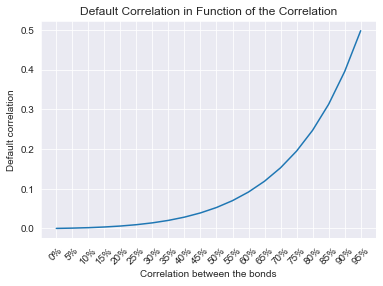

In [41]:
default_correl_df_bis = generate_default_correlation_table(portfolio=portfolio_exercice_2, transition_probability_getter_correl=transition_probability_getter, style_prc=False) # To be able to plot it !
plt.plot(default_correl_df_bis.index, default_correl_df_bis['Default Correlation'].values)
plt.xlabel('Correlation between the bonds')
plt.ylabel('Default correlation')
plt.title("Default Correlation in Function of the Correlation")
plt.xticks(rotation= 45)
plt.show()

### Part 2 - Credit Value at Risk

In [42]:
covariance_exercice_2_2 = np.array([[1, 0.99],[0.99, 1]])

In [43]:
class CreditVarEngineExercie2:
    
    def __init__(self):
        self.rating = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'Default']
    
    def compute(self, portfolio: Portfolio, 
                transition_probability_getter: TransitionProbabilityGetter, 
                model: BondValuationModel, 
                forward_market: Market, 
                horizon: int, 
                probability: float, 
                cov_matrix: np.ndarray):
        if len(portfolio.list_derivatives)!=2:
            raise ValueError("The portfolio must contains 2 bonds")
        portfolio = self.update_maturity(portfolio, horizon)
        scenarios = self.generate_scenarios(portfolio)
        scenarios_valuations = self.valuate_scenarios(scenarios, model, forward_market, horizon, portfolio)
        scenarios_probabilities = self.compute_scenario_probabilities(portfolio, scenarios, transition_probability_getter, cov_matrix)
        return self.evaluate_credit_var(scenarios_valuations, scenarios_probabilities, probability)
    
    def update_maturity(self, portfolio: Portfolio, horizon: int):
        portfolio_temp = deepcopy(portfolio)
        for bond in portfolio_temp.list_derivatives:
            bond.maturity -= horizon
        return portfolio_temp
    
    
    # Scenarios generation
    
    def generate_scenarios(self, portfolio: Portfolio):
        list_possible_rating = self.__generate_grid(portfolio)
        return self.__generate_list_portfolios(list_possible_rating, portfolio)
        
    def __generate_grid(self, portfolio: Portfolio):
        list_possible_rating = []
        for bond in portfolio.list_derivatives:
            list_possible_rating.append(deepcopy(self.rating))
        return list(itertools.product(*list_possible_rating))
        
    def __generate_list_portfolios(self, list_possible_rating: list, portfolio: Portfolio):
        scenarios = []
        for scenario in list_possible_rating:
            scenarios.append(self.__create_portfolio_scenario(scenario, portfolio))
        return scenarios
            
    def __create_portfolio_scenario(self, ratings_scenario: list, portfolio: Portfolio):
        portfolio_temp = deepcopy(portfolio)
        for i in range(len(ratings_scenario)):
            portfolio_temp.list_derivatives[i].rating = ratings_scenario[i]
        return portfolio_temp
    
    
    # Scenarios valuation - naive approach
    
    def valuate_scenarios(self, scenarios: list, model: BondValuationModel, market: Market, horizon: int, portfolio: Portfolio):
        cash_flows = self.__compute_cash_flows(portfolio, horizon)
        valuations = []
        for scena in scenarios:
            valuations.append(self.__valuate_one_scenario(portfolio=scena, model=model, market=market) + cash_flows)
        return valuations
            
    def __valuate_one_scenario(self, portfolio: Portfolio, model: BondValuationModel, market: Market):
        value = 0.0
        for bond in portfolio.list_derivatives:
            value += model.price(bond, market.get_market_data(bond.rating))
        return value
    
    def __compute_cash_flows(self, portfolio: Portfolio, horizon: int):
        cash = 0.0
        for bond in portfolio.list_derivatives:
            cash += bond.coupon_rate * bond.nominal * horizon
        return cash
    
    
    # Scenarios probability
    
    def compute_scenario_probabilities(self, portfolio: Portfolio, scenarios: list, transition_probability_getter: TransitionProbabilityGetter, cov_matrix: np.ndarray):
        scenario_probabilities = []
        for scena in scenarios:
            scenario_probabilities.append(transition_probability_getter.compute_scenario_probabilities(scena, portfolio, cov_matrix))
        return scenario_probabilities
            
    
    
    # Credit Value at Risk computation
    
    def evaluate_credit_var(self, scenarios_values: list, scenarios_probabilities: list, percentage_var: float):
        expectation = self.compute_expectation(scenarios_values, scenarios_probabilities)
        quantile = self.compute_quantile(scenarios_values, scenarios_probabilities, percentage_var)
        return expectation - quantile
    
    def compute_quantile(self, scenarios_values: list, scenarios_probabilities: list, percentage_var: float):
        # For more infos: https://www.kite.com/python/answers/how-to-sort-two-lists-together-in-python
        zipped_lists = zip(scenarios_values, scenarios_probabilities)
        sorted_pairs = sorted(zipped_lists)
        tuples = zip(*sorted_pairs)
        scenarios_values, scenarios_probabilities = [list(tuple_) for tuple_ in  tuples]
        sum_proba = 0.0
        for i in range(len(scenarios_probabilities)):
            sum_proba += scenarios_probabilities[i]
            if sum_proba > (1.0-percentage_var):
                return scenarios_values[i]
        raise ValueError('The sum of the scenarios_probabilities is below 1.0')
    
    def compute_expectation(self, scenarios_values: list, scenarios_probabilities: list):
        expectation = 0.0
        for i in range(len(scenarios_values)):
            expectation += scenarios_values[i] * scenarios_probabilities[i]
        return expectation
    
    def compute_standard_deviation(self, scenarios_values: list, scenarios_probabilities: list):
        expectation = self.compute_expectation(scenarios_values, scenarios_probabilities)
        variance = 0.0
        for i in range(len(scenarios_values)):
            variance += scenarios_probabilities[i] * (scenarios_values[i]-expectation)** 2 
        return np.sqrt(variance)
    
    def compute_proxy_credit_var(self, scenarios_values: list, scenarios_probabilities: list, percentage_var: float):
        return norm.ppf(percentage_var) * self.compute_standard_deviation(scenarios_values, scenarios_probabilities)

In [44]:
var_engine_exercice_2 = CreditVarEngineExercie2()

In [45]:
var_engine_exercice_2.compute(portfolio=portfolio_exercice_2, 
                              transition_probability_getter=transition_probability_getter, 
                              model=model, 
                              forward_market=forward_market_exercice_2, 
                              horizon=1, 
                              probability=0.99,
                              cov_matrix=covariance_exercice_2_2)

12.030838281167291

In [46]:
# Details
portfolio_temp_exercice_2 = var_engine_exercice_2.update_maturity(portfolio_exercice_2, 1)
scenarios_exercice_2 = var_engine_exercice_2.generate_scenarios(portfolio_temp_exercice_2)
scenarios_values_exercice_2 = var_engine_exercice_2.valuate_scenarios(scenarios=scenarios_exercice_2, 
                                                                      model=model, 
                                                                      horizon=1, 
                                                                      market=forward_market_exercice_2, 
                                                                      portfolio=portfolio_temp_exercice_2)
scenario_probability_exercice_2 = var_engine_exercice_2.compute_scenario_probabilities(portfolio=portfolio_temp_exercice_2, 
                                                                                       scenarios=scenarios_exercice_2, 
                                                                                       transition_probability_getter=transition_probability_getter, 
                                                                                       cov_matrix=covariance_exercice_2_2)
expectation_exercice_2 = var_engine_exercice_2.compute_expectation(scenarios_values_exercice_2, scenario_probability_exercice_2)
standard_dev_exercice_2 = var_engine_exercice_2.compute_standard_deviation(scenarios_values_exercice_2, scenario_probability_exercice_2)
quantile_99_exercice_2 = var_engine_exercice_2.compute_quantile(scenarios_values_exercice_2, scenario_probability_exercice_2, 0.99)
credit_var_exercice_2 = var_engine_exercice_2.evaluate_credit_var(scenarios_values_exercice_2, scenario_probability_exercice_2, 0.99)
proxy_credit_var_exercice_2 = var_engine_exercice_2.compute_proxy_credit_var(scenarios_values_exercice_2, scenario_probability_exercice_2, 0.99)

In [47]:
print('Expectation:', expectation_exercice_2)
print('Standard Deviation:', standard_dev_exercice_2)
print('Quantile 99%:', quantile_99_exercice_2)
print('Credit Value at Risk:', credit_var_exercice_2)
print('Proxy:', proxy_credit_var_exercice_2)

Expectation: 213.26821505718468
Standard Deviation: 4.086352257897711
Quantile 99%: 201.23737677601738
Credit Value at Risk: 12.030838281167291
Proxy: 9.50627688774233


# Exercice 3- Monte Carlo Credit Value at Risk

Please consider a portfolio of 20 bonds<br>

| Asset | Credit       Rating | Nominal                | COUPON | Maturity       (years) | Recovery Rate |
|:-----:|:-------------------:|:----------------------:|--------|:----------------------:|:-------------:|
|   1   | AAA                 |        7 000 000       |   6%   |            3           |      70%      |
|   2   | AA                  |      1 000 000         |  6,50% |            4           |      70%      |
|   3   | A                   |      1 000 000         |   7%   |            3           |      70%      |
|   4   | BBB                 |      1 000 000         |   8%   |            4           |      30%      |
|   5   | BBB                 |      1 000 000         |   8%   |            3           |      30%      |
|   6   | B                   |      1 000 000         |   10%  |            4           |      40%      |
|   7   | CCC                 |      1 000 000         |   10%  |            2           |      40%      |
|   8   | A                   |    10 000 000          |   5%   |            8           |      70%      |
|   9   | BB                  |      5 000 000         |   6%   |            2           |      40%      |
|   10  | A                   |      3 000 000         |   6%   |            2           |      70%      |
|   11  | A                   |      1 000 000         |   6%   |            4           |      70%      |
|   12  | A                   |      2 000 000         |  6,50% |            5           |      70%      |
|   13  | B                   |         600 000        |   8%   |            3           |      40%      |
|   14  | B                   |      1 000 000         |   8%   |            2           |      40%      |
|   15  | B                   |      3 000 000         |   8%   |            2           |      40%      |
|   16  | B                   |      2 000 000         |   8%   |            4           |      40%      |
|   17  | BBB                 |      1 000 000         |   10%  |            6           |      30%      |
|   18  | BBB                 |      8 000 000         |   10%  |            5           |      30%      |
|   19  | BBB                 |      1 000 000         |   10%  |            3           |      30%      |
|   20  | AA                  |      5 000 000         |   5%   |            5           |      70%      |

The aim of the exercise is to compute the Credit Value at Risk using Monte Carlo simulations. <br>
The portfolio is composed of 20 correlated bond with the folowing correlation matrix:

| Asset |       1       |       2       |       3       |         4         |       5       |       6       |           7          |        8        |        9        |        10       |        11       |        12       |        13       |        14       |        15       |        16       |        17       |        18       |        19       |        20       |
|-------|:-------------:|:-------------:|:-------------:|:-----------------:|:-------------:|:-------------:|:--------------------:|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|
| 1     |        1,0    |      0.45     |      0.45     |        0.45       |      0.15     |      0.15     |         0.15         |       0.15      |       0.15      |       0.15      |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |
| 2     |      0.45     |        1,0    |      0.45     |        0.45       |      0.15     |      0.15     |         0.15         |       0.15      |       0.15      |       0.15      |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |
| 3     |      0.45     |      0.45     |        1,0    |        0.45       |      0.15     |      0.15     |         0.15         |       0.15      |       0.15      |       0.15      |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |
| 4     |      0.45     |      0.45     |      0.45     |            1,0    |      0.15     |      0.15     |         0.15         |       0.15      |       0.15      |       0.15      |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |
| 5     |      0.15     |      0.15     |      0.15     |        0.15       |        1,0    |      0.35     |         0.35         |       0.35      |       0.35      |       0.35      |       0.2       |       0.2       |       0.2       |       0.2       |       0.2       |       0.15      |       0.15      |       0.15      |       0.1       |       0.1       |
| 6     |      0.15     |      0.15     |      0.15     |        0.15       |      0.35     |        1,0    |         0.35         |       0.35      |       0.35      |       0.35      |       0.2       |       0.2       |       0.2       |       0.2       |       0.2       |       0.15      |       0.15      |       0.15      |       0.1       |       0.1       |
| 7     |      0.15     |      0.15     |      0.15     |        0.15       |      0.35     |      0.35     |               1,0    |       0.35      |       0.35      |       0.35      |       0.2       |       0.2       |       0.2       |       0.2       |       0.2       |       0.15      |       0.15      |       0.15      |       0.1       |       0.1       |
| 8     |      0.15     |      0.15     |      0.15     |        0.15       |      0.35     |      0.35     |         0.35         |          1,0    |       0.25      |       0.35      |       0.2       |       0.2       |       0.2       |       0.2       |       0.2       |       0.15      |       0.15      |       0.15      |       0.1       |       0.1       |
| 9     |      0.15     |      0.15     |      0.15     |        0.15       |      0.35     |      0.35     |         0.35         |       0.25      |          1,0    |       0.35      |       0.2       |       0.2       |       0.2       |       0.2       |       0.2       |       0.15      |       0.15      |       0.15      |       0.1       |       0.1       |
| 10    |      0.15     |      0.15     |      0.15     |        0.15       |      0.35     |      0.35     |         0.35         |       0.35      |       0.35      |          1,0    |       0.2       |       0.2       |       0.2       |       0.2       |       0.2       |       0.15      |       0.15      |       0.15      |       0.1       |       0.1       |
| 11    |      0.1      |      0.1      |      0.1      |        0.1        |      0.2      |      0.2      |          0.2         |       0.2       |       0.2       |       0.2       |          1,0    |       0.45      |       0.45      |       0.45      |       0.45      |       0.2       |       0.2       |       0.2       |       0.1       |       0.1       |
| 12    |      0.1      |      0.1      |      0.1      |        0.1        |      0.2      |      0.2      |          0.2         |       0.2       |       0.2       |       0.2       |       0.45      |          1,0    |       0.45      |       0.45      |       0.45      |       0.2       |       0.2       |       0.2       |       0.1       |       0.1       |
| 13    |      0.1      |      0.1      |      0.1      |        0.1        |      0.2      |      0.2      |          0.2         |       0.2       |       0.2       |       0.2       |       0.45      |       0.45      |          1,0    |       0.45      |       0.45      |       0.2       |       0.2       |       0.2       |       0.1       |       0.1       |
| 14    |      0.1      |      0.1      |      0.1      |        0.1        |      0.2      |      0.2      |          0.2         |       0.2       |       0.2       |       0.2       |       0.45      |       0.45      |       0.45      |          1,0    |       0.45      |       0.2       |       0.2       |       0.2       |       0.1       |       0.1       |
| 15    |      0.1      |      0.1      |      0.1      |        0.1        |      0.2      |      0.2      |          0.2         |       0.2       |       0.2       |       0.2       |       0.45      |       0.45      |       0.45      |       0.45      |          1,0    |       0.2       |       0.2       |       0.2       |       0.1       |       0.1       |
| 16    |      0.1      |      0.1      |      0.1      |        0.1        |      0.15     |      0.15     |         0.15         |       0.15      |       0.15      |       0.15      |       0.2       |       0.2       |       0.2       |       0.2       |       0.2       |          1,0    |       0.55      |       0.55      |       0.25      |       0.25      |
| 17    |      0.1      |      0.1      |      0.1      |        0.1        |      0.15     |      0.15     |         0.15         |       0.15      |       0.15      |       0.15      |       0.2       |       0.2       |       0.2       |       0.2       |       0.2       |       0.55      |          1,0    |       0.55      |       0.25      |       0.25      |
| 18    |      0.1      |      0.1      |      0.1      |        0.1        |      0.15     |      0.15     |         0.15         |       0.15      |       0.15      |       0.15      |       0.2       |       0.2       |       0.2       |       0.2       |       0.2       |       0.55      |       0.55      |          1,0    |       0.25      |       0.25      |
| 19    |      0.1      |      0.1      |      0.1      |        0.1        |      0.1      |      0.1      |          0.1         |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.25      |       0.25      |       0.25      |          1,0    |       0.65      |
| 20    |      0.1      |      0.1      |      0.1      |        0.1        |      0.1      |      0.1      |          0.1         |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.1       |       0.25      |       0.25      |       0.25      |       0.65      |          1,0    |

### Market data

In [48]:
maturities = np.array([1, 2, 3, 4, 5, 6, 7, 8])

ir_curve = np.array([0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04])

aaa_rates = ir_curve + 0.002
aaa_ir_curve = InterestRateCurve(name='AAA', curve=aaa_rates, maturities=maturities)

aa_rates = ir_curve + 0.003
aa_ir_curve = InterestRateCurve(name='AA', curve=aa_rates, maturities=maturities)

a_rates = ir_curve + 0.005
a_ir_curve = InterestRateCurve(name='A', curve=a_rates, maturities=maturities)

bbb_rates = ir_curve + 0.015
bbb_ir_curve = InterestRateCurve(name='BBB', curve=bbb_rates, maturities=maturities)

bb_rates = ir_curve + 0.02
bb_ir_curve = InterestRateCurve(name='BB', curve=bb_rates, maturities=maturities)

b_rates = ir_curve + 0.03
b_ir_curve = InterestRateCurve(name='B', curve=b_rates, maturities=maturities)

ccc_rates = ir_curve + 0.05
ccc_ir_curve = InterestRateCurve(name='CCC', curve=ccc_rates, maturities=maturities)

default_rates = np.array([])
default_ir_curve = InterestRateCurve(name='Default', curve=default_rates, maturities=maturities)
forward_market_exercice_3 = Market([aaa_ir_curve, aa_ir_curve, a_ir_curve, bbb_ir_curve, bb_ir_curve, b_ir_curve, ccc_ir_curve, default_ir_curve])

In [49]:
covariance_exercice_3 = [[1.0, 0.45, 0.45, 0.45, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
                         [0.45, 1.0, 0.45, 0.45, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
                         [0.45, 0.45, 1.0, 0.45, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
                         [0.45, 0.45, 0.45, 1.0, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
                         [0.15, 0.15, 0.15, 0.15, 1.0, 0.35, 0.35, 0.35, 0.35, 0.35, 0.2, 0.2, 0.2, 0.2, 0.2, 0.15, 0.15, 0.15, 0.1, 0.1],
                         [0.15, 0.15, 0.15, 0.15, 0.35, 1.0, 0.35, 0.35, 0.35, 0.35, 0.2, 0.2, 0.2, 0.2, 0.2, 0.15, 0.15, 0.15, 0.1, 0.1],
                         [0.15, 0.15, 0.15, 0.15, 0.35, 0.35, 1.0, 0.35, 0.35, 0.35, 0.2, 0.2, 0.2, 0.2, 0.2, 0.15, 0.15, 0.15, 0.1, 0.1],
                         [0.15, 0.15, 0.15, 0.15, 0.35, 0.35, 0.35, 1.0, 0.25, 0.35, 0.2, 0.2, 0.2, 0.2, 0.2, 0.15, 0.15, 0.15, 0.1, 0.1],
                         [0.15, 0.15, 0.15, 0.15, 0.35, 0.35, 0.35, 0.25, 1.0, 0.35, 0.2, 0.2, 0.2, 0.2, 0.2, 0.15, 0.15, 0.15, 0.1, 0.1],
                         [0.15, 0.15, 0.15, 0.15, 0.35, 0.35, 0.35, 0.35, 0.35, 1.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.15, 0.15, 0.15, 0.1, 0.1],
                         [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1.0, 0.45, 0.45, 0.45, 0.45, 0.2, 0.2, 0.2, 0.1, 0.1],
                         [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.45, 1.0, 0.45, 0.45, 0.45, 0.2, 0.2, 0.2, 0.1, 0.1],
                         [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.45, 0.45, 1.0, 0.45, 0.45, 0.2, 0.2, 0.2, 0.1, 0.1],
                         [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.45, 0.45, 0.45, 1.0, 0.45, 0.2, 0.2, 0.2, 0.1, 0.1],
                         [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.45, 0.45, 0.45, 0.45, 1.0, 0.2, 0.2, 0.2, 0.1, 0.1],
                         [0.1, 0.1, 0.1, 0.1, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.2, 0.2, 0.2, 0.2, 0.2, 1.0, 0.55, 0.55, 0.25, 0.25],
                         [0.1, 0.1, 0.1, 0.1, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.2, 0.2, 0.2, 0.2, 0.2, 0.55, 1.0, 0.55, 0.25, 0.25],
                         [0.1, 0.1, 0.1, 0.1, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.2, 0.2, 0.2, 0.2, 0.2, 0.55, 0.55, 1.0, 0.25, 0.25],
                         [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.25, 0.25, 0.25, 1.0, 0.65],
                         [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.25, 0.25, 0.25, 0.65, 1.0]]
covariance_exercice_3 = np.array(covariance_exercice_3)

### Transition Thresholds

In [50]:
transition_thresholds_exercice_3 = {}
transition_thresholds_exercice_3['AAA'] = [-1.329, -2.382, -2.911, -3.036, -10.000, -10.000, -10.000]
transition_thresholds_exercice_3['AA'] = [2.46, -1.36, -2.38, -2.85, -2.95, -3.54, -10.0]
transition_thresholds_exercice_3['A'] = [3.12, 1.98, -1.51, -2.30, -2.72, -3.19, -3.24]
transition_thresholds_exercice_3['BBB'] = [3.540, 2.70, 1.53, -1.49, -2.18, -2.75, -2.91]
transition_thresholds_exercice_3['BB'] = [3.432, 2.929, 2.391, 1.368, -1.232, -2.042, -2.304]
transition_thresholds_exercice_3['B'] = [10.0, 3.06, 2.70, 2.42, 1.46, -1.32, -1.62]
transition_thresholds_exercice_3['CCC'] = [2.85, 2.85, 2.62, 2.11, 1.74, 1.02, -0.85]
transition_thresholds_exercice_3['Default'] = [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]

### Portfolio

In [51]:
bond_1 = Bond(rating='AAA', nominal=7000000, coupon_rate=0.06, maturity=3, recovery_rate=0.70)
bond_2 = Bond(rating='AA', nominal=1000000, coupon_rate=0.065, maturity=4, recovery_rate=0.70)
bond_3 = Bond(rating='A', nominal=1000000, coupon_rate=0.07, maturity=3, recovery_rate=0.70)
bond_4 = Bond(rating='BBB', nominal=1000000, coupon_rate=0.08, maturity=4, recovery_rate=0.30)
bond_5 = Bond(rating='BBB', nominal=1000000, coupon_rate=0.08, maturity=3, recovery_rate=0.30)
bond_6 = Bond(rating='B', nominal=1000000, coupon_rate=0.10, maturity=4, recovery_rate=0.40)
bond_7 = Bond(rating='CCC', nominal=1000000, coupon_rate=0.10, maturity=2, recovery_rate=0.40)
bond_8 = Bond(rating='A', nominal=10000000, coupon_rate=0.05, maturity=8, recovery_rate=0.70)
bond_9 = Bond(rating='BB', nominal=5000000, coupon_rate=0.06, maturity=2, recovery_rate=0.40)
bond_10 = Bond(rating='A', nominal=3000000, coupon_rate=0.06, maturity=2, recovery_rate=0.70)
bond_11 = Bond(rating='A', nominal=1000000, coupon_rate=0.06, maturity=4, recovery_rate=0.70)
bond_12 = Bond(rating='A', nominal=2000000, coupon_rate=0.065, maturity=5, recovery_rate=0.70)
bond_13 = Bond(rating='B', nominal=600000, coupon_rate=0.08, maturity=3, recovery_rate=0.40)
bond_14 = Bond(rating='B', nominal=1000000, coupon_rate=0.08, maturity=2, recovery_rate=0.40)
bond_15 = Bond(rating='B', nominal=3000000, coupon_rate=0.08, maturity=2, recovery_rate=0.40)
bond_16 = Bond(rating='B', nominal=2000000, coupon_rate=0.08, maturity=4, recovery_rate=0.40)
bond_17 = Bond(rating='BBB', nominal=1000000, coupon_rate=0.10, maturity=6, recovery_rate=0.30)
bond_18 = Bond(rating='BBB', nominal=8000000, coupon_rate=0.10, maturity=5, recovery_rate=0.30)
bond_19 = Bond(rating='BBB', nominal=1000000, coupon_rate=0.10, maturity=3, recovery_rate=0.30)
bond_20 = Bond(rating='AA', nominal=5000000, coupon_rate=0.05, maturity=5, recovery_rate=0.70)
portfolio_exercice_3 = Portfolio(list_derivatives=[bond_1, bond_2, bond_3, bond_4, bond_5, bond_6, bond_7,
                                                  bond_8, bond_9, bond_10, bond_11, bond_12, bond_13, bond_14,
                                                  bond_15, bond_16, bond_17, bond_18, bond_19, bond_20])

In [52]:
value_init = 0.0
i = 0
for bond in portfolio_exercice_3.list_derivatives:
    value_init += model.price(bond, forward_market_exercice_3.get_market_data(bond.rating))
    print("Bond_"+str(i)+"'s value:", round(model.price(bond, forward_market_exercice_3.get_market_data(bond.rating))))
    i += 1
print()
print("Portfolio's initial value:", round(value_init))

Bond_0's value: 7348338.0
Bond_1's value: 1079296.0
Bond_2's value: 1068724.0
Bond_3's value: 1087629.0
Bond_4's value: 1067448.0
Bond_5's value: 1101616.0
Bond_6's value: 1017591.0
Bond_7's value: 10329794.0
Bond_8's value: 5000000.0
Bond_9's value: 3084270.0
Bond_10's value: 1053813.0
Bond_11's value: 2175599.0
Bond_12's value: 615746.0
Bond_13's value: 1018080.0
Bond_14's value: 3054241.0
Bond_15's value: 2067744.0
Bond_16's value: 1224799.0
Bond_17's value: 9537302.0
Bond_18's value: 1121407.0
Bond_19's value: 5154509.0

Portfolio's initial value: 59207948.0


### Credit Value at Risk

In [53]:
class CreditVarEngineExercie3:
    
    def __init__(self):
        self.rating = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'Default']
    
    def compute(self, portfolio: Portfolio, model: BondValuationModel, forward_market: Market, horizon: int, probability: float, cov_matrix: np.ndarray, nb_simulations: int, transition_thresholds: dict):
        portfolio = deepcopy(portfolio)
        portfolio = self.update_maturity(portfolio, horizon)
        scenarios = self.generate_scenarios(portfolio, cov_matrix, nb_simulations, transition_thresholds)
        scenarios_valuation = self.valuate_scenarios(scenarios=scenarios, model=model, horizon=horizon, market=forward_market, portfolio=portfolio)
        return self.evaluate_credit_var(scenarios_valuation, probability)
    
    def update_maturity(self, portfolio: Portfolio, horizon: int):
        portfolio_temp = deepcopy(portfolio)
        for bond in portfolio.list_derivatives:
            bond.maturity -= horizon
        return portfolio_temp
    
    
    # Scenarios generation
    
    def generate_scenarios(self, portfolio: Portfolio, cov_matrix: np.ndarray, nb_simulations: int, transition_thresholds: dict):
        mean_vector = np.array([[0] for i in range(len(portfolio.list_derivatives))])
        #gaussians_correlated = np.random.multivariate_normal(mean_vector, cov_vector, nb_simulations)
        gaussians_correlated = self.__generate_gaussian_correlated(nb_simulations, len(portfolio.list_derivatives), mean_vector, cov_matrix)
        gaussians_correlated = gaussians_correlated.T
        list_scenarios_rating = self.__generate_list_scenarios_rating(gaussians_correlated, transition_thresholds, portfolio)
        return self.__generate_list_portfolios(list_scenarios_rating, portfolio)
    
    def __generate_gaussian_correlated(self, nb_simulations: int, nb_dimension: int, mean_vector: np.ndarray, cov_vector: np.ndarray):
        L = np.linalg.cholesky(cov_vector)
        X = np.random.normal(size=(nb_dimension, nb_simulations))
        return L.dot(X) + mean_vector
    
    def __generate_list_scenarios_rating(self, gaussians_correlated, transition_thresholds, portfolio: Portfolio):
        ratings = []
        for correlated_vector in gaussians_correlated:
            ratings.append(self.__from_random_variables_to_ratings(gaussian_vector=correlated_vector, transition_thresholds=transition_thresholds, portfolio=portfolio))
        return ratings
    
    def __from_random_variables_to_ratings(self, gaussian_vector, transition_thresholds: dict, portfolio: Portfolio):
        one_rating_scenarios = []
        i = 0
        for random_variable in gaussian_vector:
            if random_variable > transition_thresholds[portfolio.list_derivatives[i].rating][0]:
                one_rating_scenarios.append('AAA')
            elif random_variable > transition_thresholds[portfolio.list_derivatives[i].rating][1]:
                one_rating_scenarios.append('AA')
            elif random_variable > transition_thresholds[portfolio.list_derivatives[i].rating][2]:
                one_rating_scenarios.append('A')
            elif random_variable > transition_thresholds[portfolio.list_derivatives[i].rating][3]:
                one_rating_scenarios.append('BBB')
            elif random_variable > transition_thresholds[portfolio.list_derivatives[i].rating][4]:
                one_rating_scenarios.append('BB')
            elif random_variable > transition_thresholds[portfolio.list_derivatives[i].rating][5]:
                one_rating_scenarios.append('B')
            elif random_variable > transition_thresholds[portfolio.list_derivatives[i].rating][6]:
                one_rating_scenarios.append('CCC')
            else:
                one_rating_scenarios.append('Default')
            i+=1
        return one_rating_scenarios
    
    def __generate_list_portfolios(self, list_possible_rating: list, portfolio: Portfolio):
        scenarios = []
        for scenario in list_possible_rating:
            scenarios.append(self.__create_portfolio_scenario(scenario, portfolio))
        return scenarios
            
    def __create_portfolio_scenario(self, ratings_scenario: list, portfolio: Portfolio):
        portfolio_temp = deepcopy(portfolio)
        for i in range(len(ratings_scenario)):
            portfolio_temp.list_derivatives[i].rating = ratings_scenario[i]
        return portfolio_temp
    
    

    # Scenarios valuation - grid approach
    
    def valuate_scenarios(self, scenarios: list, model: BondValuationModel, market: Market, horizon: int, portfolio: Portfolio):
        cash_flows = self.__compute_cash_flows(portfolio, horizon)
        # print('cash_flows=', cash_flows)
        possible_valuation_grid = self.compute_each_valuation_grid(portfolio, model, market)
        # print(possible_valuation_grid)
        valuations = []
        for scena in scenarios:
            valuations.append(self.__valuate_one_scenario(portfolio=scena, model=model, market=market, valuation_grid=possible_valuation_grid) + cash_flows)
        return valuations
            
    def __valuate_one_scenario(self, portfolio: Portfolio, model: BondValuationModel, market: Market, valuation_grid: list):
        value = 0.0
        i=0
        for bond in portfolio.list_derivatives:
            value += valuation_grid[i][bond.rating]
            i+=1
        return value 
    
    def compute_each_valuation_grid(self, portfolio: Portfolio, model: BondValuationModel, market: Market):
        valuation_grid = []
        for bond in portfolio.list_derivatives:
            valuation_grid.append(self.__compute_each_possible_bond_values(bond, model, market))
        return valuation_grid
    
    def __compute_each_possible_bond_values(self, bond: Bond, model: BondValuationModel, market: Market):
        possible_values = {}
        bond_temp = deepcopy(bond)
        for ra in self.rating:
            bond_temp.rating = ra
            possible_values[ra] = model.price(bond_temp, market.get_market_data(bond_temp.rating))
        return possible_values
    
    def __compute_cash_flows(self, portfolio: Portfolio, horizon: int):
        cash = 0.0
        for bond in portfolio.list_derivatives:
            cash += bond.coupon_rate * bond.nominal * horizon
        return cash
    
    
    # Credit Value at Risk computation
    
    def evaluate_credit_var(self, scenarios_values: list, percentage_var: float):
        quantile = self.compute_quantile(scenarios_values, percentage_var)
        expectation = self.compute_expectation(scenarios_values)
        return expectation - quantile
    
    def compute_quantile(self, scenarios_values: list, percentage_var: float):
        return np.quantile(scenarios_values, 1-percentage_var)
    
    def compute_proxy_credit_var(self, scenarios_values: list, percentage_var: float):
        return norm.ppf(percentage_var) * self.compute_standard_deviation(scenarios_values)
                
    def compute_expectation(self, scenarios_values: list):
        return np.mean(scenarios_values)
    
    def compute_standard_deviation(self, scenarios_values: list):
        return np.std(scenarios_values)

In [54]:
var_engine_exercice_3 = CreditVarEngineExercie3()

In [55]:
var_engine_exercice_3.compute(portfolio=portfolio_exercice_3, 
                              model=model, 
                              forward_market=forward_market_exercice_3, 
                              horizon=1, 
                              probability=0.99,
                              cov_matrix=covariance_exercice_3,
                              nb_simulations=10000,
                              transition_thresholds=transition_thresholds_exercice_3
                             )

3751799.1583882347

In [56]:
portfolio_temp = var_engine_exercice_3.update_maturity(portfolio_exercice_3, 1)
scenarios_exercice_3 = var_engine_exercice_3.generate_scenarios(portfolio=portfolio_exercice_3, cov_matrix=covariance_exercice_3, nb_simulations=10000, transition_thresholds=transition_thresholds_exercice_3)
scenarios_values_exercice_3 = var_engine_exercice_3.valuate_scenarios(scenarios=scenarios_exercice_3, model=model, horizon=1, market=forward_market_exercice_3, portfolio=portfolio_exercice_3)
expectation_exercice_3 = var_engine_exercice_3.compute_expectation(scenarios_values_exercice_3)
standard_dev_exercice_3 = var_engine_exercice_3.compute_standard_deviation(scenarios_values_exercice_3)
quantile_exercice_3 = var_engine_exercice_3.compute_quantile(scenarios_values_exercice_3, 0.99)
credit_var_exercice_3 = var_engine_exercice_3.evaluate_credit_var(scenarios_values_exercice_3, 0.99)
proxy_credit_var_exercice_3 = var_engine_exercice_3.compute_proxy_credit_var(scenarios_values_exercice_3, 0.99)

In [57]:
print('Expectation:', int(expectation_exercice_3))
print('Standard Deviation:', int(standard_dev_exercice_3))
print('Quantile:', int(quantile_exercice_3))
print('Credit Value at Risk:', int(credit_var_exercice_3))
print('Proxy:', int(proxy_credit_var_exercice_3))

Expectation: 61814775
Standard Deviation: 968864
Quantile: 58124686
Credit Value at Risk: 3690089
Proxy: 2253916


# Exercice 4 - Monte Carlo Credit Value at Risk with Stochastic Recovery Rate

In the folowing exercice, please consider the exact same exercice than the the exercice 3 (Monte Carlo Credit Value at Risk), but with stochastic recovery rate. <br>
The recovery is not constant, this is interesting to measure the risk due to this hypothethis by considering it stochastic this time. <br>
Please find below the mean and standard deviation of the recovery rate by seniority class.

| Seniority Class     | Mean   (%) | Standard Deviation |
|---------------------|------------|--------------------|
| Senior Secured      | 53,80      | 26,86              |
| Senior Unsecured    | 51,13      | 25,45              |
| Senior Subordinated | 38,52      | 23,81              |
| Subordinated        | 32,74      | 20,18              |
| Junior Subordinated | 17,09      | 10,90              |

The aim of the exercice is to compute the Credit VaR with this new hypothethis, and to deduce the risk associated to considering it constant.

### Recovery - Seniority Class

In [58]:
seniority_recovery = {}
seniority_recovery['Senior Secured'] = [53.80, 26.86]
seniority_recovery['Senior Unsecured'] = [51.13, 25.45]
seniority_recovery['Senior Subordinated'] = [38.52, 23.81]
seniority_recovery['Subordinated'] = [32.74, 20.18]
seniority_recovery['Junior Subordinated'] = [17.09, 10.90]

In [59]:
seniority_recovery_zero_std = {}
seniority_recovery_zero_std['Senior Secured'] = [53.80, 0.0]
seniority_recovery_zero_std['Senior Unsecured'] = [51.13, 0.0]
seniority_recovery_zero_std['Senior Subordinated'] = [38.52, 0.0]
seniority_recovery_zero_std['Subordinated'] = [32.74, 0.0]
seniority_recovery_zero_std['Junior Subordinated'] = [17.09, 0.0]

### Bond

In [60]:
class BondExercice4:
    
    def __init__(self, rating: str, nominal: float, coupon_rate: float, maturity: int, recovery_rate: float, seniority_class: str):
        self.rating = rating
        self.nominal = nominal
        self.coupon_rate = coupon_rate
        self.maturity = maturity
        self.recovery_rate = recovery_rate
        self.seniority_class = seniority_class

### Portfolio Exercice 4

In [61]:
bond_1 = BondExercice4(rating='AAA', nominal=7000000, coupon_rate=0.06, maturity=3, recovery_rate=0.00, seniority_class='Senior Secured')
bond_2 = BondExercice4(rating='AA', nominal=1000000, coupon_rate=0.065, maturity=4, recovery_rate=0.00, seniority_class='Senior Unsecured')
bond_3 = BondExercice4(rating='A', nominal=1000000, coupon_rate=0.07, maturity=3, recovery_rate=0.00, seniority_class='Senior Subordinated')
bond_4 = BondExercice4(rating='BBB', nominal=1000000, coupon_rate=0.08, maturity=4, recovery_rate=0.00, seniority_class='Junior Subordinated')
bond_5 = BondExercice4(rating='BBB', nominal=1000000, coupon_rate=0.08, maturity=3, recovery_rate=0.00, seniority_class='Junior Subordinated')
bond_6 = BondExercice4(rating='B', nominal=1000000, coupon_rate=0.10, maturity=4, recovery_rate=0.00, seniority_class='Junior Subordinated')
bond_7 = BondExercice4(rating='CCC', nominal=1000000, coupon_rate=0.10, maturity=2, recovery_rate=0.00, seniority_class='Junior Subordinated')
bond_8 = BondExercice4(rating='A', nominal=10000000, coupon_rate=0.05, maturity=8, recovery_rate=0.00, seniority_class='Senior Secured')
bond_9 = BondExercice4(rating='BB', nominal=5000000, coupon_rate=0.06, maturity=2, recovery_rate=0.00, seniority_class='Subordinated')
bond_10 = BondExercice4(rating='A', nominal=3000000, coupon_rate=0.06, maturity=2, recovery_rate=0.00, seniority_class='Senior Secured')
bond_11 = BondExercice4(rating='A', nominal=1000000, coupon_rate=0.06, maturity=4, recovery_rate=0.00, seniority_class='Senior Secured')
bond_12 = BondExercice4(rating='A', nominal=2000000, coupon_rate=0.065, maturity=5, recovery_rate=0.00, seniority_class='Senior Secured')
bond_13 = BondExercice4(rating='B', nominal=600000, coupon_rate=0.08, maturity=3, recovery_rate=0.00, seniority_class='Junior Subordinated')
bond_14 = BondExercice4(rating='B', nominal=1000000, coupon_rate=0.08, maturity=2, recovery_rate=0.00, seniority_class='Junior Subordinated')
bond_15 = BondExercice4(rating='B', nominal=3000000, coupon_rate=0.08, maturity=2, recovery_rate=0.00, seniority_class='Junior Subordinated')
bond_16 = BondExercice4(rating='B', nominal=2000000, coupon_rate=0.08, maturity=4, recovery_rate=0.00, seniority_class='Junior Subordinated')
bond_17 = BondExercice4(rating='BBB', nominal=1000000, coupon_rate=0.10, maturity=6, recovery_rate=0.00, seniority_class='Subordinated')
bond_18 = BondExercice4(rating='BBB', nominal=8000000, coupon_rate=0.10, maturity=5, recovery_rate=0.00, seniority_class='Subordinated')
bond_19 = BondExercice4(rating='BBB', nominal=1000000, coupon_rate=0.10, maturity=3, recovery_rate=0.00, seniority_class='Subordinated')
bond_20 = BondExercice4(rating='AA', nominal=5000000, coupon_rate=0.05, maturity=5, recovery_rate=0.00, seniority_class='Senior Secured')
portfolio_exercice_4 = Portfolio(list_derivatives=[bond_1, bond_2, bond_3, bond_4, bond_5, bond_6, bond_7,
                                                  bond_8, bond_9, bond_10, bond_11, bond_12, bond_13, bond_14,
                                                  bond_15, bond_16, bond_17, bond_18, bond_19, bond_20])

### Credit Value at Risk

In [62]:
class CreditVarEngineExercie4:
    
    def __init__(self):
        self.rating = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'Default']
    
    def compute(self, portfolio: Portfolio, model: BondValuationModel, forward_market: Market, horizon: int, probability: float, cov_matrix: np.ndarray, nb_simulations: int, transition_thresholds: dict, seniority_recovery: dict):
        portfolio = deepcopy(portfolio)
        portfolio = self.update_maturity(portfolio, horizon)
        scenarios = self.generate_scenarios(portfolio, cov_matrix, nb_simulations, transition_thresholds)
        recovery_scenarios = self.generate_recovery_scenarios(seniority_recovery, nb_simulations)
        scenarios_valuation = self.valuate_scenarios(scenarios=scenarios, model=model, horizon=horizon, market=forward_market, portfolio=portfolio, recovery_scenarios=recovery_scenarios)
        return self.evaluate_credit_var(scenarios_valuation, probability)
    
    def update_maturity(self, portfolio: Portfolio, horizon: int):
        portfolio_temp = deepcopy(portfolio)
        for bond in portfolio.list_derivatives:
            bond.maturity -= horizon
        return portfolio_temp
    
    
    # Scenarios generation
    
    def generate_scenarios(self, portfolio: Portfolio, cov_matrix: np.ndarray, nb_simulations: int, transition_thresholds: dict):
        mean_vector = np.array([[0] for i in range(len(portfolio.list_derivatives))])
        #gaussians_correlated = np.random.multivariate_normal(mean_vector, cov_vector, nb_simulations)
        gaussians_correlated = self.__generate_gaussian_correlated(nb_simulations, len(portfolio.list_derivatives), mean_vector, cov_matrix)
        gaussians_correlated = gaussians_correlated.T
        list_scenarios_rating = self.__generate_list_scenarios_rating(gaussians_correlated, transition_thresholds, portfolio)
        return self.__generate_list_portfolios(list_scenarios_rating, portfolio)
    
    def __generate_gaussian_correlated(self, nb_simulations: int, nb_dimension: int, mean_vector: np.ndarray, cov_vector: np.ndarray):
        L = np.linalg.cholesky(cov_vector)
        X = np.random.normal(size=(nb_dimension, nb_simulations))
        return L.dot(X) + mean_vector
    
    def __generate_list_scenarios_rating(self, gaussians_correlated, transition_thresholds, portfolio: Portfolio):
        ratings = []
        for correlated_vector in gaussians_correlated:
            ratings.append(self.__from_random_variables_to_ratings(gaussian_vector=correlated_vector, transition_thresholds=transition_thresholds, portfolio=portfolio))
        return ratings
    
    def __from_random_variables_to_ratings(self, gaussian_vector, transition_thresholds: dict, portfolio: Portfolio):
        one_rating_scenarios = []
        i = 0
        for random_variable in gaussian_vector:
            if random_variable > transition_thresholds[portfolio.list_derivatives[i].rating][0]:
                one_rating_scenarios.append('AAA')
            elif random_variable > transition_thresholds[portfolio.list_derivatives[i].rating][1]:
                one_rating_scenarios.append('AA')
            elif random_variable > transition_thresholds[portfolio.list_derivatives[i].rating][2]:
                one_rating_scenarios.append('A')
            elif random_variable > transition_thresholds[portfolio.list_derivatives[i].rating][3]:
                one_rating_scenarios.append('BBB')
            elif random_variable > transition_thresholds[portfolio.list_derivatives[i].rating][4]:
                one_rating_scenarios.append('BB')
            elif random_variable > transition_thresholds[portfolio.list_derivatives[i].rating][5]:
                one_rating_scenarios.append('B')
            elif random_variable > transition_thresholds[portfolio.list_derivatives[i].rating][6]:
                one_rating_scenarios.append('CCC')
            else:
                one_rating_scenarios.append('Default')
            i+=1
        return one_rating_scenarios
    
    def __generate_list_portfolios(self, list_possible_rating: list, portfolio: Portfolio):
        scenarios = []
        for scenario in list_possible_rating:
            scenarios.append(self.__create_portfolio_scenario(scenario, portfolio))
        return scenarios
            
    def __create_portfolio_scenario(self, ratings_scenario: list, portfolio: Portfolio):
        portfolio_temp = deepcopy(portfolio)
        for i in range(len(ratings_scenario)):
            portfolio_temp.list_derivatives[i].rating = ratings_scenario[i]
        return portfolio_temp
    
    def generate_recovery_scenarios(self, seniority_recovery: dict, nb_simulations: int):
        mean_vector = []
        std_dev_vector = []
        for seniorty in seniority_recovery.keys():
            mean_vector.append(seniority_recovery[seniorty][0]/100)
            std_dev_vector.append(seniority_recovery[seniorty][1]/100)
        return np.random.normal(0, 1, (nb_simulations, len(seniority_recovery))) * np.array(std_dev_vector) + np.array(mean_vector)
        

    # Scenarios valuation - grid approach
    
    def valuate_scenarios(self, scenarios: list, model: BondValuationModel, market: Market, horizon: int, portfolio: Portfolio, recovery_scenarios: np.ndarray):
        cash_flows = self.__compute_cash_flows(portfolio, horizon)
        valuations = []
        i = 0
        for scena in scenarios:
            valuations.append(self.__valuate_one_scenario(portfolio=scena, model=model, market=market, recovery_one_scenario=recovery_scenarios[i]) + cash_flows)
            i += 1
        return valuations
            
    def __valuate_one_scenario(self, portfolio: Portfolio, model: BondValuationModel, market: Market, recovery_one_scenario: np.ndarray):
        value = 0.0
        for bond in portfolio.list_derivatives:
            bond = self.change_recovery_rate(bond, recovery_one_scenario)
            value += model.price(bond, market.get_market_data(bond.rating))
        return value
    
    def change_recovery_rate(self, bond: Bond, recovery_one_scenario: np.ndarray):
        if bond.seniority_class=='Senior Secured':
            bond.recovery_rate = recovery_one_scenario[0]
        elif bond.seniority_class=='Senior Unsecured':
            bond.recovery_rate = recovery_one_scenario[1]
        elif bond.seniority_class=='Senior Subordinated':
            bond.recovery_rate = recovery_one_scenario[2]
        elif bond.seniority_class=='Subordinated':
            bond.recovery_rate = recovery_one_scenario[3]
        elif bond.seniority_class=='Junior Subordinated':
            bond.recovery_rate = recovery_one_scenario[4]
        else:
            raise ValueError('The seniority_class is not valid.')
        return bond
    
    def __compute_cash_flows(self, portfolio: Portfolio, horizon: int):
        cash = 0.0
        for bond in portfolio.list_derivatives:
            cash += bond.coupon_rate * bond.nominal * horizon
        return cash
    
    
    # Credit Value at Risk computation
    
    def evaluate_credit_var(self, scenarios_values: list, percentage_var: float):
        quantile = self.compute_quantile(scenarios_values, percentage_var)
        expectation = self.compute_expectation(scenarios_values)
        return expectation - quantile
    
    def compute_quantile(self, scenarios_values: list, percentage_var: float):
        return np.quantile(scenarios_values, 1-percentage_var)
    
    def compute_proxy_credit_var(self, scenarios_values: list, percentage_var: float):
        return norm.ppf(percentage_var) * self.compute_standard_deviation(scenarios_values)
                
    def compute_expectation(self, scenarios_values: list):
        return np.mean(scenarios_values)
    
    def compute_standard_deviation(self, scenarios_values: list):
        return np.std(scenarios_values)

In [63]:
var_engine_exercice_4 = CreditVarEngineExercie4()

In [64]:
var_engine_exercice_4.compute(portfolio=portfolio_exercice_4, 
                              model=model, 
                              forward_market=forward_market_exercice_3, 
                              horizon=1, 
                              probability=0.99,
                              cov_matrix=covariance_exercice_3,
                              nb_simulations=20000,
                              transition_thresholds=transition_thresholds_exercice_3,
                              seniority_recovery=seniority_recovery
                             )

4845537.042670183

In [65]:
var_recovery_without_std = var_engine_exercice_4.compute(portfolio=portfolio_exercice_4, 
                              model=model, 
                              forward_market=forward_market_exercice_3, 
                              horizon=1, 
                              probability=0.99,
                              cov_matrix=covariance_exercice_3,
                              nb_simulations=20000,
                              transition_thresholds=transition_thresholds_exercice_3,
                              seniority_recovery=seniority_recovery_zero_std
                             )

In [66]:
var_recovery_without_std

4767307.471524641

In [67]:
portfolio_temp = var_engine_exercice_4.update_maturity(portfolio_exercice_4, 1)
scenarios_exercice_4 = var_engine_exercice_4.generate_scenarios(portfolio=portfolio_exercice_4, cov_matrix=covariance_exercice_3, nb_simulations=20000, transition_thresholds=transition_thresholds_exercice_3)
recovery_scenarios_exercice_4 = var_engine_exercice_4.generate_recovery_scenarios(seniority_recovery, 20000)
scenarios_values_exercice_4 = var_engine_exercice_4.valuate_scenarios(scenarios=scenarios_exercice_4, model=model, horizon=1, market=forward_market_exercice_3, portfolio=portfolio_exercice_4, recovery_scenarios=recovery_scenarios_exercice_4)
expectation_exercice_4 = var_engine_exercice_4.compute_expectation(scenarios_values_exercice_4)
standard_dev_exercice_4 = var_engine_exercice_4.compute_standard_deviation(scenarios_values_exercice_4)
quantile_exercice_4 = var_engine_exercice_4.compute_quantile(scenarios_values_exercice_4, 0.99)
credit_var_exercice_4 = var_engine_exercice_4.evaluate_credit_var(scenarios_values_exercice_4, 0.99)
proxy_credit_var_exercice_4 = var_engine_exercice_4.compute_proxy_credit_var(scenarios_values_exercice_4, 0.99)

In [68]:
print('Expectation:', int(expectation_exercice_4))
print('Standard Deviation:', int(standard_dev_exercice_4))
print('Quantile:', int(quantile_exercice_4))
print('Credit Value at Risk:', int(credit_var_exercice_4))
print('Proxy:', int(proxy_credit_var_exercice_4))
print('Approximated risk due to the stochastic recovery rate:', int(credit_var_exercice_4-var_recovery_without_std))

Expectation: 61671858
Standard Deviation: 1229191
Quantile: 56753897
Credit Value at Risk: 4917961
Proxy: 2859527
Approximated risk due to the stochastic recovery rate: 150653
